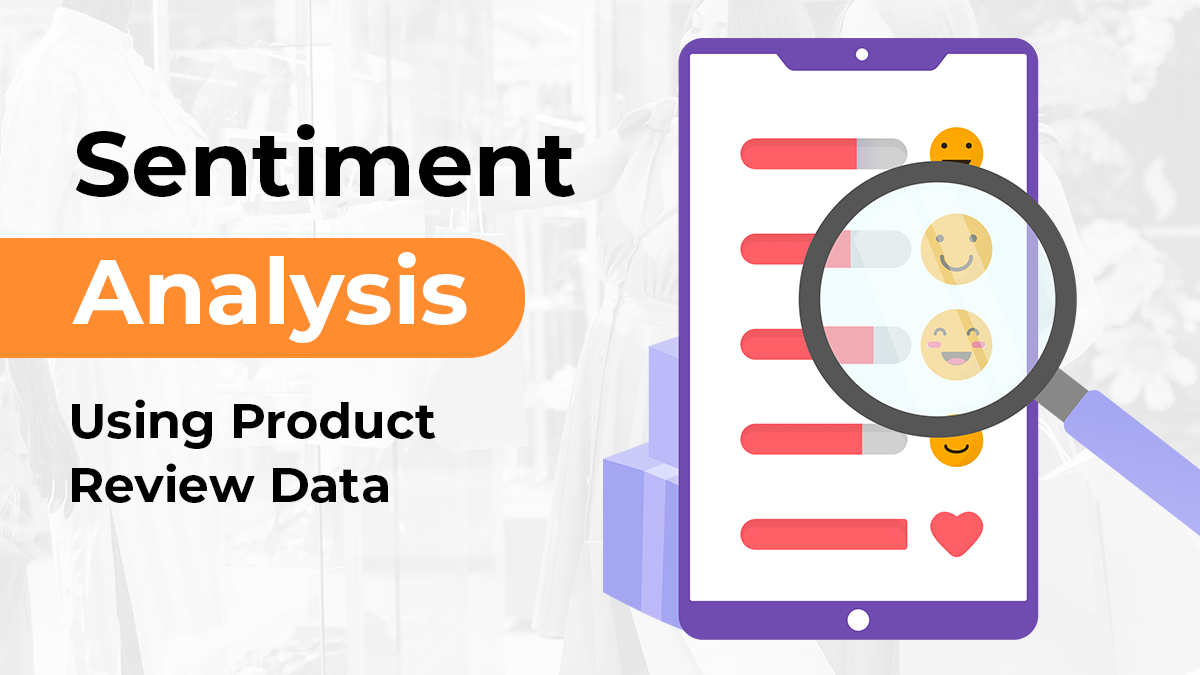

In [21]:
from IPython import display
display.Image("https://www.revuze.it/wp-content/uploads/2019/07/sentiment-analysis.png")

# Table of Content

* [Intro](#intro)
* [Importing packages and loading data](#imp)
* [Dataset Description](#dd)
* [Exploratory Data Analysis (EDA)](#eda)
* [Analysis](#as)
    * [Splitting Dataset into Train and Test Set](#stts)
    * [Feature Engineering and Selection](#fe)
    * [Models](#ml)
        * [Multinominal Naive Bayes](#mnb)
        * [Logistic Regression Classifier](#lrc)
        * [Support Vector Machine Classifier](#svmc)
    * [Confusion Matrix](#cm)
* [Conclusion and Future Work](#cfr)
* [References](#ref)
    

<a id='intro'></a>
# Sentiment Analysis

Sentiment analysis of product reviews, an application problem, has recently become very popular in text mining
and computational linguistics research. Here, we want to study the correlation between the Amazon product reviews
and the rating of the products given by the customers. We use traditional machine learning algorithms including Naive Bayes analysis, Support Vector Machines and Logistic Regression. By comparing these results, we could get a better understanding of the these algorithms. They could also act as a supplement to other fraud scoring detection methods.

<a id='imp'></a>
# Importing packages and loading data

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") # Plotting style
%matplotlib inline 
np.random.seed(7) # seeding random number generator

csv = "./Dataset/1429_1.csv"
df = pd.read_csv(csv)

<a id='dd'></a>
# Dataset Description

Our dataset comes from **Consumer Reviews of Amazon Products**.This dataset has **34660** data points in total. Each example includes the type, name of the product as well as the text review and the rating of the product. To better utilize the data, first we extract the rating and review column since these two are the essential part of this project.Then, we found that there are some data points which has no ratings when we went through the data. After eliminating those examples, we have **34627** data points in **total**.



In [23]:
print("Data points before elimination : ",len(df))
df=df.dropna(subset=["reviews.rating"])
print("Data points after elimination : ",len(df))
df.head(2)

Data points before elimination :  34660
Data points after elimination :  34627


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


<a id='eda'></a>
## Exploratory Data Analysis (EDA)

To have a brief overview of the dataset, we have plot the distribution of the ratings.it shows that we have 5 classes - rating 1 to 5 as well as the distribution among them. Also, these five classes are actually imbalanced as class 1 and class 2 have small amount of data while class 5 has more than 20000 reviews.  


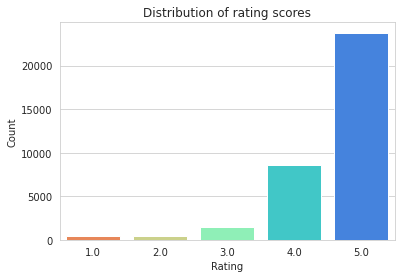

In [24]:
sns.countplot(df['reviews.rating'], palette='rainbow_r')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#### Due to the high imbalance of our dataset, we find and added more datapoints with low ratings from other resources.
We think this might help us solve the problem of data imbalance.

In [25]:
# load the other dataset
df2 = pd.read_csv("./Dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv("./Dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Eliminating data points which has no ratings
df2=df2.dropna(subset=["reviews.rating"])
df3=df3.dropna(subset=["reviews.rating"])

# using only data of rating lower than or equal to 3 and resetting index after filtering rows
df2 = df2[df2["reviews.rating"] <= 3].reset_index(drop=True) 
df3 = df3[df3["reviews.rating"] <= 3].reset_index(drop=True)
df2['reviews.rating'].value_counts().sort_index(ascending=False)
df3['reviews.rating'].value_counts().sort_index(ascending=False)

# concatenation
data = pd.concat([df, df2, df3])
len(data)

37728

In [26]:
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,7.000000e+00,35532.000000,37728.000000,0.0,0.0
mean,1.572322e+08,0.659293,4.382077,NaN,NaN
std,4.189041e+07,13.524891,1.008872,NaN,NaN
min,1.082112e+08,0.000000,1.000000,NaN,NaN
25%,1.150383e+08,0.000000,4.000000,NaN,NaN
50%,1.867536e+08,0.000000,5.000000,NaN,NaN
75%,1.884934e+08,0.000000,5.000000,NaN,NaN
max,1.985974e+08,814.000000,5.000000,NaN,NaN


Based on the descriptive statistics above, we see the following:
- Average review score has decreased to 4.38, with low standard deviation
    - Most review are positive from 2nd quartile onwards
- The average for number of reviews helpful (reviews.numHelpful) is 0.65 but high standard deviation
    - The data are pretty spread out around the mean, and since can't have negative people finding something helpful, then this is only on the right tail side
    - The range of most reviews will be between 0-13 people finding helpful (reviews.numHelpful)
- The most helpful review was helpful to 814 people
    - This could be a detailed, rich review that will be worth looking at

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37728 entries, 0 to 313
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    37728 non-null  object 
 1   name                  30969 non-null  object 
 2   asins                 37726 non-null  object 
 3   brand                 37728 non-null  object 
 4   categories            37728 non-null  object 
 5   keys                  37728 non-null  object 
 6   manufacturer          37728 non-null  object 
 7   reviews.date          37699 non-null  object 
 8   reviews.dateAdded     24086 non-null  object 
 9   reviews.dateSeen      37728 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   35457 non-null  object 
 12  reviews.id            7 non-null      float64
 13  reviews.numHelpful    35532 non-null  float64
 14  reviews.rating        37728 non-null  float64
 15  reviews.sourceURLs   

Based on the information above:
- Drop reviews.userCity, reviews.userProvince, reviews.id, and reviews.didPurchase since these values are floats (for exploratory analysis only)
- Not every category have maximum number of values in comparison to total number of values
- reviews.text category has minimum missing data (37727/37728) -> Good news!
- We need to clean up the name column by referencing asins (unique products) since we have 7000 missing values

In [28]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B01AHB9CYG',
       'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2', 'B018Y229OU',
       'B00REQKWGA', 'B00IOYAM4I', 'B018T075DC', nan, 'B00DU15MU4',
       'B018Y225IA', 'B005PB2T2Q', 'B018Y23MNM', 'B00OQVZDJM',
       'B00IOY8XWQ', 'B00LO29KXQ', 'B00QJDU3KY', 'B018Y22C2Y',
       'B01BFIBRIE', 'B01J4ORNHU', 'B018SZT3BK', 'B00UH4D8G2',
       'B018Y22BI4', 'B00TSUGXKE', 'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K',
       'B00X4WHP5E', 'B00QFQRELG', 'B00LW9XOJM', 'B00QL1ZN3G',
       'B0189XYY0Q', 'B01BH83OOM', 'B00U3FPN4U', 'B002Y27P6Y',
       'B006GWO5NE', 'B006GWO5WK', 'B00QWO9P0O,B00LH3DMUO',
       'B00DIHVMEA,B00EZ1ZTV0', 'B00QWO9P0O,B01IB83NZG,B00MNV8E0C',
       'B00WRDS8H0', 'B00EEBS9O0,B01CHQHIJK',
       'B01B66989K,B00CD8ADKO,B00LA9H6UM', 'B00DUGZFWY',
       'B00F5CKWBA,B00KPQCWAU', 'B006BGZJJ4', 'B00Y3QOH5G', 'B00BGIQS1A',
       'B018SZT3BK,B01AHB9CN2', 'B018Y226XO', 'B01ACEKAJY', 'B01IO618J8',
       'B01AHBBG04', 'B01AHBDCKQ', 'B0

In [29]:
asins_unique = len(data["asins"].unique())
print("Number of Unique ASINs: " + str(asins_unique))

Number of Unique ASINs: 72


Next, we will explore the following columns:
- asins
- reviews.rating
- (reviews.numHelpful - not possible since numHelpful is only between 0-13 as per previous analysis in Raw Data)
- (reviews.text - not possible since text is in long words)



##  reviews.rating / ASINs

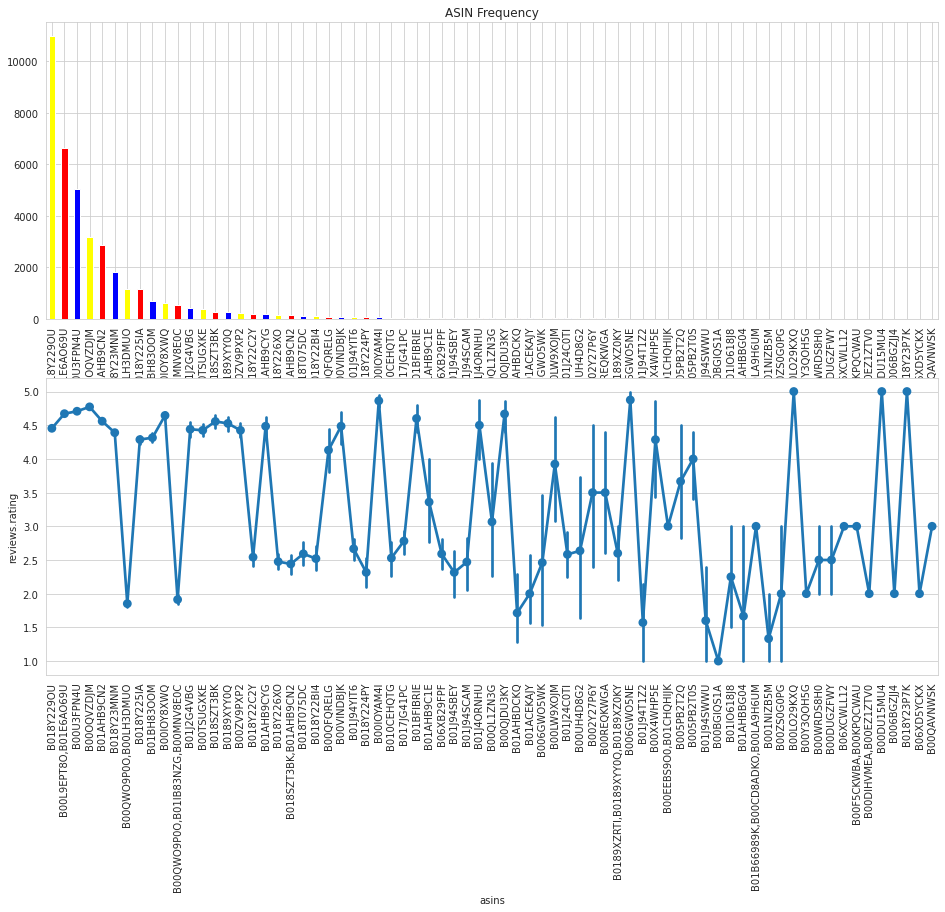

In [30]:
asins_count_ix = data["asins"].value_counts().index
plt.subplots(2,1,figsize=(16,12))
plt.subplot(2,1,1)
data["asins"].value_counts().plot(kind="bar", title="ASIN Frequency",color=['yellow', 'red', 'blue'])
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=data )
plt.xticks(rotation=90)
plt.show()

- 1a) The most frequently reviewed products have their average review ratings in the 4.5 - 4.8 range, with little variance
- 1b) Although there is a slight inverse relationship between the ASINs frequency level and average review ratings for the first 4 ASINs, this relationship is not significant since the average review for the first 4 ASINs are rated between 4.5 - 4.8, which is considered good overall reviews
- 2a) For ASINs with lower frequencies as shown on the bar graph (top), we see that their corresponding average review ratings on the point-plot graph (bottom) has significantly higher variance as shown by the length of the vertical lines. As a result, we suggest that, the average review ratings for ASINs with lower frequencies are not significant for our analysis due to high variance
- 2b) On the other hand, due to their lower frequencies for ASINs with lower frequencies, we suggest that this is a result of lower quality products
- 2c) Furthermore, the last 4 ASINs have no variance due to their significantly lower frequencies, and although the review ratings are a perfect 5.0, but we should not consider the significance of these review ratings due to lower frequency as explained in 2a)

**<u>Note</u> that point-plot graph automatically takes the average of the review.rating data.**

<a id='as'></a>
#  Analysis
Using the features in place, we will build a classifier that can determine a review's sentiment.

### Set Target Variable (Sentiments)
Segregate ratings from 1-5 into positive, neutral, and negative.

In [31]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"


<a id='stts' ></a>
## Splitting Dataset into Train and Test Set
- Before we explore the dataset we're going to split it into training set and test sets
- Our goal is to eventually train a sentiment analysis classifier
- Since the majority of reviews are positive (5 stars), we will need to do a stratified split on the reviews score to ensure that we don't train the classifier on imbalanced data
- To use sklearn's `train_test_split` class, we're going to covert all review rating to `integer` datatype

In [35]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
data["reviews.rating"] = data["reviews.rating"].astype(int)
data["Sentiment"] = data["reviews.rating"].apply(sentiments)

X_train, X_test,y_train, y_test = train_test_split(
    data["reviews.text"], data["Sentiment"] , test_size=0.20, random_state=42, stratify= data["reviews.rating"] )

In [36]:
print("Training Sample :",len(X_train))
print("Testing sample :", len(X_test))

Training Sample : 30182
Testing sample : 7546


<a id='fe'></a>
## Feature Engineering and Selection

Here we will turn content into numerical feature vectors using the **Bag of Words** strategy:
- **Assign fixed integer id to each word occurrence (integer indices to word occurrence dictionary)**
- **X[i,j] where i is the integer indices, j is the word occurrence, and X is an array of words (our training set)**
<br>
<br>

In order to implement the **Bag of Words** strategy, we will use SciKit-Learn's **CountVectorizer** to performs the following:
- Text preprocessing:
    - Tokenization (breaking sentences into words)
    - Stopwords (filtering "the", "are", etc)
- Occurrence counting (builds a dictionary of features from integer indices with word occurrences)
- Feature Vector (converts the dictionary of text documents into a feature vector)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer 

# Replace "nan" with space
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
y_train = y_train.fillna(' ')
y_test = y_test.fillna(' ')

# Text preprocessing and occurance counting

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape
print("Training Sample :",(X_train_counts.shape[0]))
print("Distinct Words :", (X_train_counts.shape[1]))

Training Sample : 30182
Distinct Words : 13296


With longer documents, we typically see higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use **TfidfTransformer** to reduce this redundancy:
- **Term Frequencies (Tf) divides number of occurrences for each word by total number of words**
- **Term Frequencies times Inverse Document Frequency (Tfidf) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)**

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


<a id='ml'></a>
# Models

<a id='mnb'></a>
## Multinominal Naive Bayes

- Multinominal Niave Bayes is most suitable for word counts where data are typically represented as word vector counts (number of times outcome number X[i,j] is observed over the n trials), while also ignoring non-occurrences of a feature i
- Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed conditioned independent to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

<img src="https://i.imgur.com/uBAzSpr.jpeg">

In [48]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, y_train)
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == y_test)

0.8723827193214948

<a id='lrc'></a>
## Logistic Regression Classifier

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

<img src="https://editor.analyticsvidhya.com/uploads/18130oL4Ox_JxTBi-DsfycUwYvw_d0582a0dddf7470486f0955c8b025dd6_Screen-Shot-2020-09-01-at-8.30.00-AM.png">

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)
print('Accuracy: {}'. format(accuracy_score(y_test, predictedLogReg)))

Accuracy: 0.9077657036840711


<a id='svm'></a>
## Support Vector Machine Classifier
“Support Vector Machine” (SVM) is a supervised machine learning algorithm that can be used for both classification or regression challenges. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well 

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/10/SVM_1.png">

In [50]:

from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, y_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == y_test)

0.9223429631592897

**Looks like all the models performed well,but we will use the Support Vector Machine Classifier since it has the highest accuracy level at 92.23%.**

#### Classification report
- Precision: determines how many objects selected were correct
- Recall: tells you how many of the objects that should have been selected were actually selected
- F1 score measures the weights of recall and precision (1 means precision and recall are equally important, 0 otherwise)
- Support is the number of occurrences of each class

In [51]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test,predictedLinearSVC))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedLinearSVC)))

              precision    recall  f1-score   support

    Negative       0.80      0.73      0.76       502
     Neutral       0.66      0.41      0.51       581
    Positive       0.94      0.98      0.96      6463

    accuracy                           0.92      7546
   macro avg       0.80      0.71      0.75      7546
weighted avg       0.91      0.92      0.92      7546

Accuracy: 0.9223429631592897


<a id='cm'></a>
## Confusion Matrix 

Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. This gives us a holistic view of how well our classification model is performing and what kinds of errors it is making.

In [52]:
from sklearn import metrics
metrics.confusion_matrix(y_test, predictedLinearSVC)

array([[ 365,   42,   95],
       [  63,  241,  277],
       [  28,   81, 6354]])

<a id='cfr'></a>
## Conclusion and Future Work

The results in this analysis confirms our previous data exploration analysis, where the data are very skewed to the positive reviews as shown by the lower support counts in the classification report. Also, both neutral and negative reviews has large standard deviation with small frequencies, which we would not consider significant as shown by the lower precision, recall and F1 scores in the classification report.

**However, despite that Neutral and Negative results are not very strong predictors in this data set, it still shows a 92.23% accuracy level in predicting the sentiment analysis. Therefore, we are comfortable here with the skewed data set. Also, as we continue to input new dataset in the future that is more balanced, this model will then re-adjust to a more balanced classifier which will increase the accuracy level.**

<u>Note</u>: The first row will be ignored as we previously replaced all NAN with " ". We tried to remove this row when we first imported the raw data, but Pandas `DataFrame` did not like this row removed when we tried to drop all NAN (before stratifying and splitting the dataset). As a result, replacing the NAN with " " was the best workaround and the first row will be ignored in this analysis.

Finally, the overall result here explains that the products in this dataset are generally positively rated.

From the analysis above in the classification report, we can see that products with lower reviews are not significant enough to predict these lower rated products are inferior. On the other hand, products that are highly rated are considered superior products, which also performs well and should continue to sell at a high level.

As a result, we need to input more data in order to consider the significance of lower rated product, in order to determine which products should be dropped from Amazon's product roster.

The good news is that despite the skewed dataset, we were still able to build a robust Sentiment Analysis machine learning system to determine if the reviews are positive or negative. This is possible as the machine learning system was able to learn from all the positive, neutral and negative reviews, and fine tune the algorithm in order to avoid bias sentiments. 

**In conclusion, although we need more data to balance out the lower rated products to consider their significance, however we were still able to successfully associate positive, neutral and negative sentiments for each product in Amazon's Catalog.**

<a id='ref'></a>
### References
* [Create a Pipeline to Perform Sentiment Analysis using NLP](https://www.analyticsvidhya.com/blog/2020/11/create-a-pipeline-to-perform-sentiment-analysis-using-nlp/)
* [Support Vector Machine(SVM) algorithm](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)
* [Naive Bayes Algorithm](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-naive-bayes-algorithm/)
* [Confusion Matrix](https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/)
* [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
* [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)